In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.dates as mdates

In [2]:
# Load COVID-19 case data
# TODO: download most recent data
raw = pd.read_csv('05-05-2020.csv')

# Drop unnecessary columns and remove all regions that are not US counties
raw = raw.drop(['FIPS', 'Last_Update', 'Long_'], axis=1)
raw.drop(raw[raw['Country_Region'] != 'US'].index, inplace=True)
raw.dropna(inplace=True)

# Rename columns
raw.rename(columns={'Lat':'Latitude', 'Combined_Key': 'County'},inplace=True)

# Set 'Combined_Key' as index
raw = raw.groupby('County').sum()

# Filter out counties with less than min_sample_size
min_sample_size = 5000
raw = raw[raw['Confirmed'] >= min_sample_size]

raw

,Latitude,Confirmed,Deaths,Recovered,Active
County,,,,,
"Bergen, New Jersey, US",40.960109,16460,1261,0,15199
"Broward, Florida, US",26.151847,5492,215,0,5277
"Cook, Illinois, US",41.841448,45223,1922,0,43301
"District of Columbia, District of Columbia, US",38.904178,5322,264,0,5058
"Essex, Massachusetts, US",42.668763,9979,527,0,9452
"Essex, New Jersey, US",40.786813,14840,1319,0,13521
"Fairfield, Connecticut, US",41.268099,12360,935,0,11425
"Harris, Texas, US",29.860000,7128,144,0,6984
"Hartford, Connecticut, US",41.802830,6351,804,0,5547


In [3]:
# Calculate death rate for each country
def cal_death_rate(total_deaths, total_confirmed):
    death_rate = pd.Series(dtype = float)
    
    # Calculating death rate
    if (total_deaths.index == total_confirmed.index).all():
        death_rate = total_deaths/(total_confirmed + total_deaths)
    else:
        print('Whoops, looks like your countries dont match')
    
    # Drop countries that have a null death rate (don't have any cases)
    death_rate.dropna(inplace=True)
    
    death_rate = pd.DataFrame(death_rate)
    death_rate.rename(columns={death_rate.columns[0]:'Death Rate'},inplace=True)
    
    return death_rate

# Get most recent numbers for comfirmed and deaths
total_confirmed = raw['Confirmed']
total_deaths = raw['Deaths']

# Calculate death rate
death_rate = cal_death_rate(total_deaths, total_confirmed)

death_rate

,Death Rate
County,
"Bergen, New Jersey, US",0.071159
"Broward, Florida, US",0.037673
"Cook, Illinois, US",0.040768
"District of Columbia, District of Columbia, US",0.047261
"Essex, Massachusetts, US",0.050162
"Essex, New Jersey, US",0.081626
"Fairfield, Connecticut, US",0.070327
"Harris, Texas, US",0.019802
"Hartford, Connecticut, US",0.112369


In [4]:
# Merge two data sets
def merge_data1(covid_data, geo_data):
    df = geo_data.merge(covid_data, left_index=True, right_index=True)
    
    # Check missing countries
    print(f'We lost {covid_data.shape[0] - df.shape[0]} countries in our merge')
    
    return df
    

def merge_data2(covid_data, raw):
    df = pd.concat([raw, covid_data], axis=1)
    df = df.drop(['Confirmed', 'Deaths', 'Recovered', 'Active'], axis=1)
    return df

# Death Rates and Latitude
death_and_lat = merge_data2(death_rate, raw)
death_and_lat

,Latitude,Death Rate
County,,
"Bergen, New Jersey, US",40.960109,0.071159
"Broward, Florida, US",26.151847,0.037673
"Cook, Illinois, US",41.841448,0.040768
"District of Columbia, District of Columbia, US",38.904178,0.047261
"Essex, Massachusetts, US",42.668763,0.050162
"Essex, New Jersey, US",40.786813,0.081626
"Fairfield, Connecticut, US",41.268099,0.070327
"Harris, Texas, US",29.860000,0.019802
"Hartford, Connecticut, US",41.802830,0.112369


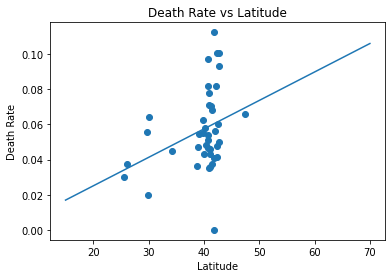

p-values: 0.03688776035823032
R^2: 0.10694645418978166
Slope: 0.0016183989222999038


In [5]:
# Plot linear regression
def lin_regress(merged_data, col_death, col_data, line_length):
    # Linear regression using scipy
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged_data[col_data], merged_data[col_death])
    predictions = np.linspace(15,line_length,5) * slope + intercept
    
    # Visualize using plt
    plt.scatter(merged_data[col_data], merged_data[col_death])
    plt.ylabel(col_death)
    plt.xlabel(col_data)
    plt.title(f'{col_death} vs {col_data}')
    plt.plot(np.linspace(15,line_length,5), predictions)
    plt.show()
    
    # Print important values
    print(f'p-values: {p_value}')
    print(f'R^2: {r_value*r_value}')
    print(f'Slope: {slope}')
    

lin_regress(death_and_lat, 'Death Rate', 'Latitude', 70)